<a href="https://colab.research.google.com/github/cory-yemen/RU-Thesis-Dissertation-Latex-Template/blob/master/metropolitan_migration_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to create migration measures by metro

In [12]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from google.colab import drive
drive.mount('/content/gdrive')
from matplotlib.pyplot import figure
import networkx as nx
from functools import reduce
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
# Function to get the counties in an msa
def get_msa_by_county():
    
    df = pd.read_excel('/content/gdrive/My Drive/dissertation/omb2013Definitions.xlsx',  
                       dtype = {'state_fips': str, 'county_fips': str})\
        .query('county_fips == county_fips & msa != "Micropolitan Statistical Area" & type != "Outlying"')\
        .assign(combined_fips = lambda x: x['state_fips'] + x['county_fips'])\
        [['cbsa_code', 'cbsa_name', 'county', 'state_name', 'combined_fips', 'state_fips', 'county_fips']]
    
    return df

# Function to get amenities by county (ERS)
def get_ers_amenity_index_by_county():
    
    df = pd.read_excel('/content/gdrive/My Drive/dissertation/ers_amenities.xlsx', 
                       dtype = {'combined_fips': str, 'Division': str})\
        .rename(columns = {'Division': 'division'})\
        .drop(['fips'], axis = 1)
    
    return df

# Function to get OMB 2013 definitions on ERS data
def get_amenity_by_metro():
    
    omb_df = get_msa_by_county()
    
    ers_df = get_ers_amenity_index_by_county()
    
    df = pd.merge(omb_df, 
                  ers_df, 
                  on = 'combined_fips', 
                  how = 'inner')\
        .groupby(['cbsa_code'])\
        .agg({'amenity_scale': [np.mean, np.median, np.max]})
    
    return df

def get_colnames_from_first_row(df):
    
    df.columns = df.iloc[0].str.lower()
    df = df[1:]
    
    return df

# Function to get median rent and population
def get_rent_and_pop_acs_detail(year):
    
    if year == 2011:
        base = 'https://api.census.gov/data/2011/acs/acs3?get='
        
    else:
        base = 'https://api.census.gov/data/2007/acs/acs3?get='
        
    variables = 'CBSA,NAME,B25064_001E,B01001_001E,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E'
    geo = '&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*'
    apikey = '&key=1ee5fd27e75dbba2bf4e3471b323a1be9c1e6b49'
    
    df = get_colnames_from_first_row(pd.read_json(base + variables + geo + apikey))\
        .assign(median_rent = lambda x: x['b25064_001e'].astype('int64'), 
                total_pop = lambda x: x['b01001_001e'].astype('int64'), 
                over65 = lambda x: x['b01001_020e'].astype('int64') + x['b01001_021e'].astype('int64') \
                + x['b01001_022e'].astype('int64') + x['b01001_023e'].astype('int64') + x['b01001_024e'].astype('int64') \
                + x['b01001_025e'].astype('int64') + x['b01001_044e'].astype('int64') + x['b01001_045e'].astype('int64') \
                + x['b01001_046e'].astype('int64') + x['b01001_047e'].astype('int64') + x['b01001_048e'].astype('int64') \
                + x['b01001_049e'].astype('int64'), 
                pctOver65 = lambda x: np.divide(x['over65'].astype('float'), x['total_pop'].astype('float')))\
        .rename(columns = {'cbsa': 'cbsa_code', 'name': 'cbsa_name', 'median_rent': 'median_rent_' + str(year), 
                           'total_pop': 'total_pop_' + str(year), 'pctOver65': 'pctOver65_' + str(year)})\
        [['cbsa_code', 'cbsa_name', 'median_rent_' + str(year), 'total_pop_' + str(year), 'pctOver65_' + str(year)]]
        
    return df

# Function to get epop
def get_epop_detail(year):

    if year == 2011:
        base = 'https://api.census.gov/data/2011/acs/acs3/profile?get='

    else:
        base = 'https://api.census.gov/data/2007/acs/acs3/profile?get='

    variables = 'CBSA,NAME,DP03_0007PE'
    geo = '&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*'
    apikey = '&key=1ee5fd27e75dbba2bf4e3471b323a1be9c1e6b49'

    df = get_colnames_from_first_row(pd.read_json(base + variables + geo + apikey))\
        .assign(epop = lambda x: (100 - x['dp03_0007pe'].astype(float))/100)\
        .rename(columns = {'cbsa': 'cbsa_code', 'name': 'cbsa_name', 'epop': 'epop_' + str(year)})\
        [['cbsa_code', 'cbsa_name', 'epop_' + str(year)]]

    return df

# Function to get average comp
def get_comp():

    df = pd.read_excel('/content/gdrive/My Drive/dissertation/averageComp.xls', dtype = {'GeoFips': np.str})\
        .rename(columns = {'GeoFips': 'cbsa_code', 'GeoName': 'cbsa_name', '2007': 'comp_2007', '2011': 'comp_2011'})

    return df

# Calculate distance in miles
def distance_calc(origin, destination):

    dist = geodesic(origin, destination).miles

    return dist

# Vectorize the distance calculation
vectorized_distance_calc = np.vectorize(distance_calc)


# Function to calculate distances
def get_distances():

    df = pd.read_excel('/content/gdrive/My Drive/dissertation/metareaGeoCoded2.xlsx', dtype = {'MSA': np.str})\
        .set_index('MSA')

    pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.to_list()]))\
        .reset_index()\
        .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
        .assign(lat_s = lambda x: x['cbsa_s'].map(df['lat']), 
                lon_s = lambda x: x['cbsa_s'].map(df['lon']), 
                lat_r = lambda x: x['cbsa_r'].map(df['lat']), 
                lon_r = lambda x: x['cbsa_r'].map(df['lon']), 
                coordinates_s = lambda x: tuple(zip(x['lat_s'], x['lon_s'])), 
                coordinates_r = lambda x: tuple(zip(x['lat_r'], x['lon_r'])), 
                distance = lambda x: vectorized_distance_calc(x['coordinates_s'], x['coordinates_r']))

    return pairs

# Function to calculate distances using metarea2013
def get_distances_2013():

    df = pd.read_csv('/content/gdrive/My Drive/dissertation/munisGeocoded.txt', sep = '|', dtype = {'Fips': np.str})\
        .set_index('Fips')

    pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.to_list()]))\
        .reset_index()\
        .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
        .assign(lat_s = lambda x: x['cbsa_s'].map(df['lat']), 
                lon_s = lambda x: x['cbsa_s'].map(df['lon']), 
                lat_r = lambda x: x['cbsa_r'].map(df['lat']), 
                lon_r = lambda x: x['cbsa_r'].map(df['lon']), 
                coordinates_s = lambda x: tuple(zip(x['lat_s'], x['lon_s'])), 
                coordinates_r = lambda x: tuple(zip(x['lat_r'], x['lon_r'])), 
                distance = lambda x: vectorized_distance_calc(x['coordinates_s'], x['coordinates_r']))   

    return pairs


# Function to get density
def get_density():

    df = pd.read_excel('/content/gdrive/My Drive/dissertation/density.xlsx', 'density', dtype = {'cbsa_code': np.str})

    return df

# Function to get density ratios
def get_density_ratio():

    df = get_density()\
        .set_index('cbsa_code')

    pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.tolist()]))\
        .reset_index()\
        .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
        .assign(density_2007_s = lambda x: x['cbsa_s'].map(df['dens_2007']), 
                density_2007_r = lambda x: x['cbsa_r'].map(df['dens_2007']), 
                density_2007_ratio = lambda x: x['density_2007_r'] / x['density_2007_s'], 
                density_2007_ratio_n = lambda x: (x['density_2007_ratio'] - x['density_2007_ratio'].mean()) / x['density_2007_ratio'].std(), 
                density_2011_s = lambda x : x['cbsa_s'].map(df['dens_2011']), 
                density_2011_r = lambda x: x['cbsa_r'].map(df['dens_2011']), 
                density_2011_ratio = lambda x: x['density_2011_r'] / x['density_2011_s'], 
                density_2011_ratio_n = lambda x: (x['density_2011_ratio'] - x['density_2011_ratio'].mean()) / x['density_2011_ratio'].std())

    return pairs

# Function to get amenity ratios
def get_amenity_ratio():
    '''Uses the max amenity level of the metro '''
    
    df = get_amenity_by_metro()
    df.columns = df.columns.droplevel(0)

    pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.tolist()]))\
        .reset_index()\
        .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
        .assign(amenity_index_s = lambda x: x['cbsa_s'].map(df['amax']), 
                amenity_index_r = lambda x: x['cbsa_r'].map(df['amax']), 
                amenity_index_ratio = lambda x: x['amenity_index_r'] / x['amenity_index_s'])

    return pairs

# Function to get wage ratios
def get_comp_ratio():

    df = get_comp()\
        .set_index('cbsa_code')
        
    pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.tolist()]))\
        .reset_index()\
        .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
        .assign(comp_2007_s = lambda x: x['cbsa_s'].map(df['comp_2007']), 
                comp_2007_r = lambda x: x['cbsa_r'].map(df['comp_2007']), 
                comp_2007_ratio = lambda x: x['comp_2007_r'] / x['comp_2007_s'], 
                comp_2011_s = lambda x: x['cbsa_s'].map(df['comp_2011']), 
                comp_2011_r = lambda x: x['cbsa_r'].map(df['comp_2011']), 
                comp_2011_ratio = lambda x: x['comp_2011_r'] / x['comp_2011_s'])  
        
    return pairs

# Function to get rent and epop ratios
def get_rent_and_pop_acs_detail_ratio(year):

    df = get_rent_and_pop_acs_detail(year)\
        .set_index('cbsa_code')

    pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.tolist()]))\
        .reset_index()\
        .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
        .assign(median_rent_s = lambda x: x['cbsa_s'].map(df['median_rent_' + str(year)]), 
                median_rent_r = lambda x: x['cbsa_r'].map(df['median_rent_' + str(year)]), 
                median_rent_ratio = lambda x: x['median_rent_r'] / x['median_rent_s'], 
                total_pop_s = lambda x: x['cbsa_s'].map(df['total_pop_' + str(year)]), 
                total_pop_r = lambda x: x['cbsa_r'].map(df['total_pop_' + str(year)]), 
                total_pop_ratio = lambda x: x['total_pop_r'] / x['total_pop_s'], 
                pct_over_65_s = lambda x: x['cbsa_s'].map(df['total_pop_' + str(year)]), 
                pct_over_65_r = lambda x: x['cbsa_r'].map(df['total_pop_' + str(year)]), 
                pct_over_65_ratio = lambda x: x['pct_over_65_r'] / x['pct_over_65_s'])

    return pairs 

# Function to get epop ratios
def get_epop_detail_ratio(year):

    df = get_epop_detail(year)\
        .set_index('cbsa_code')
        
    pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.tolist()]))\
        .reset_index()\
        .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
        .assign(epop_s = lambda x: x['cbsa_s'].map(df['epop_' + str(year)]), 
                epop_r = lambda x: x['cbsa_r'].map(df['epop_' + str(year)]), 
                epop_ratio = lambda x: x['epop_r'] / x['epop_s'])
        
    return pairs


# Function to translate migmet to metaread
def get_migmet_crosswalk():

    metxwalk = pd.read_excel('/content/gdrive/My Drive/dissertation/metareas_crosswalk.xlsx')\
        .set_index('metaread')

    df = pd.read_parquet('/content/gdrive/My Drive/dissertation/ipums_mig.parquet')\
        .assign(migmet2013 = lambda x: x['migmet1'].map(metxwalk['met2013']))\
        .assign(migmet2013 = lambda x: np.where(x['migmet1'] == 0, 0, x['migmet2013']))

    return df

# Function to get network centrality by metro and year
def get_centrality_measures(df, year, dimension):

    if dimension == 'all':
        df = df\
            .query('migmet1 != 0 & metaread != 0 & met2013 != 0 & migmet2013 != 0 & year == ' + str(year))\
            .groupby(['migmet2013', 'met2013'])['perwt']\
            .sum()\
            .to_frame()\
            .reset_index()\
            .assign(migmet2013 = lambda x: x['migmet2013'].astype('int64'))

        suffix = '_all_' + str(year)

    else:
        df = df\
            .query('migmet1 != 0 & metaread != 0 & met2013 != 0 & migmet2013 != 0 & year == ' + str(year) + ' & ' + dimension + ' > 0')\
            .groupby(['migmet2013', 'met2013'])['perwt']\
            .sum()\
            .to_frame()\
            .reset_index()\
            .assign(migmet2013 = lambda x: x['migmet2013'].astype('int64'))

        suffix = '_' + dimension + '_' + str(year)

    G = nx.from_pandas_edgelist(df, source = 'migmet2013', target = 'met2013', edge_attr = 'perwt', create_using = nx.DiGraph())
    nx.set_node_attributes(G, nx.degree_centrality(G), 'deg_cent' + suffix)
    nx.set_node_attributes(G, nx.betweenness_centrality(G, normalized = True, weight = 'perwt'), 'bet_cent' + suffix)
    nx.set_node_attributes(G, nx.in_degree_centrality(G), 'in_deg_cent' + suffix)
    nx.set_node_attributes(G, nx.out_degree_centrality(G), 'out_deg_cent' + suffix)
    nx.set_node_attributes(G, nx.eigenvector_centrality(G, weight = 'perwt'), 'eig_cent' + suffix)
    nx.set_node_attributes(G, nx.pagerank(G, weight = 'perwt'), 'page_rank' + suffix)
    nx.set_node_attributes(G, nx.hits(G)[0], 'hub_score' + suffix)
    nx.set_node_attributes(G, nx.hits(G)[1], 'auth_score' + suffix)

    dfOut = pd.DataFrame.from_dict(dict(G.nodes(data = True)), orient = 'index')
    dfOut[dfOut.columns] = MinMaxScaler().fit_transform(dfOut[dfOut.columns])


    return G, dfOut

# Function to get all centrality measures for each creative type
def get_all_centrality_measures(df):

    variables = ['all','Florida_cclass', 'Florida_ccore', 'Florida_cprof', 'Gabe_cclass', 'cy_high', 'cy_cclass', 'cy_math', 'cy_comm', 'cy_dynd']

    df_list = []
    for i, var in enumerate(variables):
        for j, yr in enumerate([2007, 2011]):
            _, df_s = get_centrality_measures(df, yr, var)
            df_list.append(df_s)

    dfOut = reduce(lambda x, y: pd.merge(x, y, left_index = True, right_index = True, how = 'outer'), df_list)

    return dfOut


# Pairplot centrality measures by year
def pair_plot_centrality(df, year):

    #variables = ['all', 'Florida_cclass', 'Gabe_cclass', 'cy_high', 'cy_cclass', 'cy_math', 'cy_comm', 'cy_dynd']
    variables = ['all']

    df_list = []
    for var in variables:
        _, df_s = get_centrality_measures(df, year, var)
        df_list.append(df_s)

    dfOut = reduce(lambda x, y: pd.merge(x, y, left_index = True, right_index = True, how = 'outer'), df_list)
    dfOut.columns = [x.rsplit('_', 1)[0] for x in dfOut.columns]

    p = sns.pairplot(dfOut, diag_kind = None, kind = 'scatter')

    return p

In [5]:
df = get_migmet_crosswalk()

In [47]:
test = get_all_centrality_measures(df)

In [60]:
test.sort_values(['eig_cent_all_2007'], ascending = False)[['eig_cent_all_2007']]

,eig_cent_all_2007
35620,1.000000
31080,0.045892
37980,0.025090
33100,0.021812
12060,0.020001
...,...
30620,0.000000
46220,0.000000
30980,0.000000
43780,0.000000


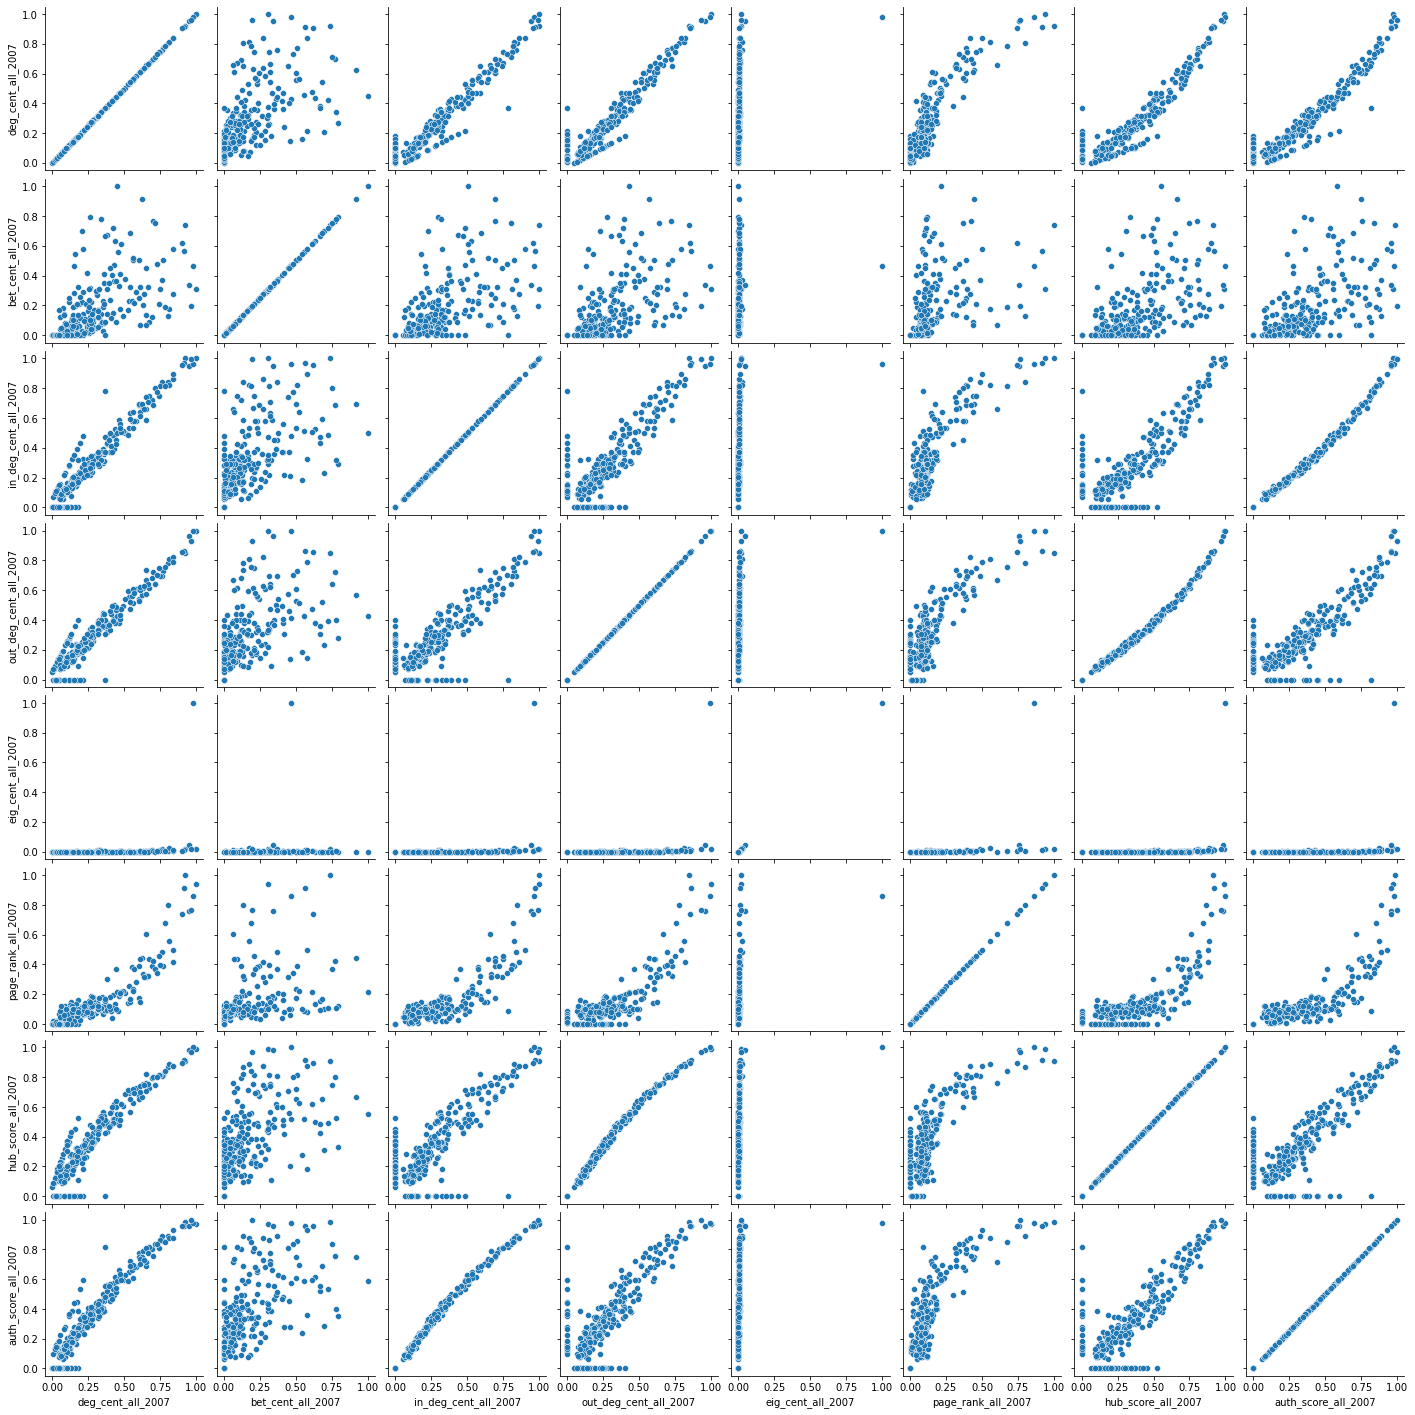

In [53]:
mask = [col for col in test.columns.tolist() if col.rsplit('_',1)[1] == '2007' and col.rsplit('_',2)[1] == 'all']
sns.pairplot(test[mask], diag_kind = None, kind = 'scatter')

In [ ]:
g = sns.pairplot(test[['Florida_cclass_']])

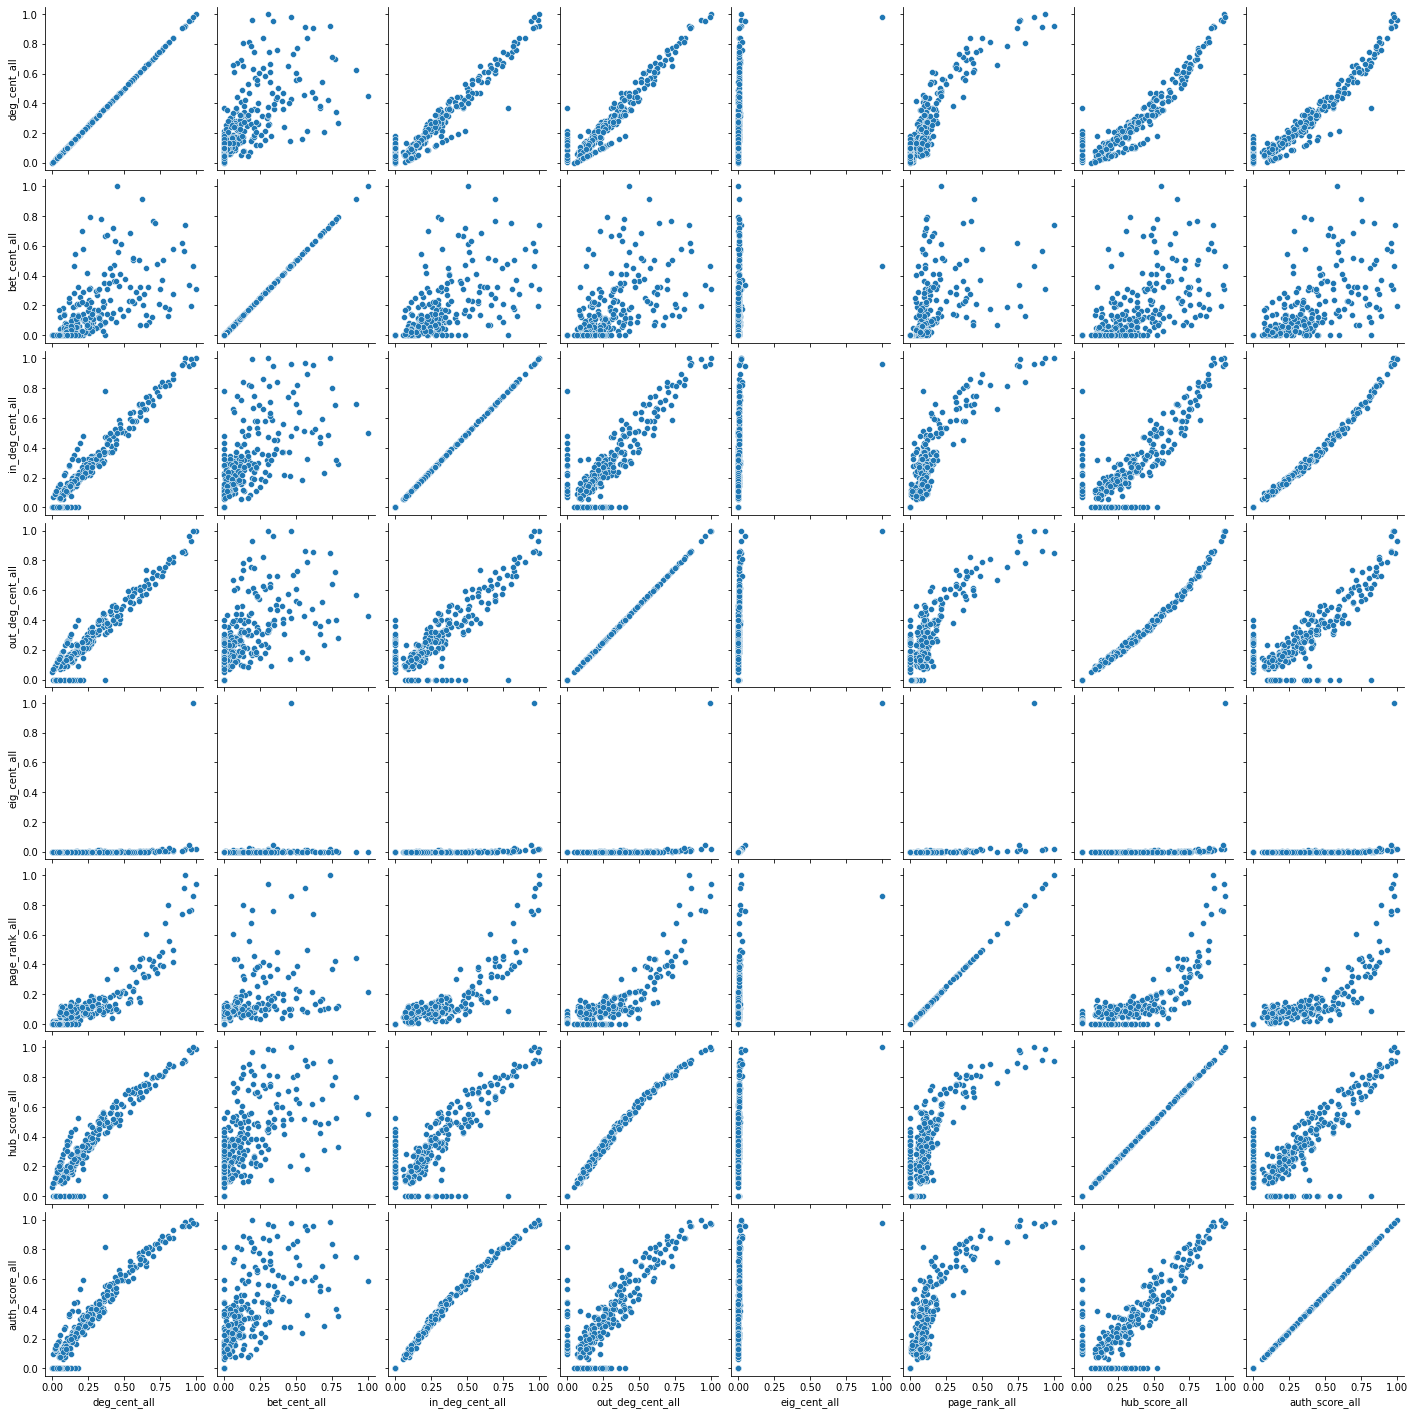

In [54]:
pair_plot_centrality(df, 2007)

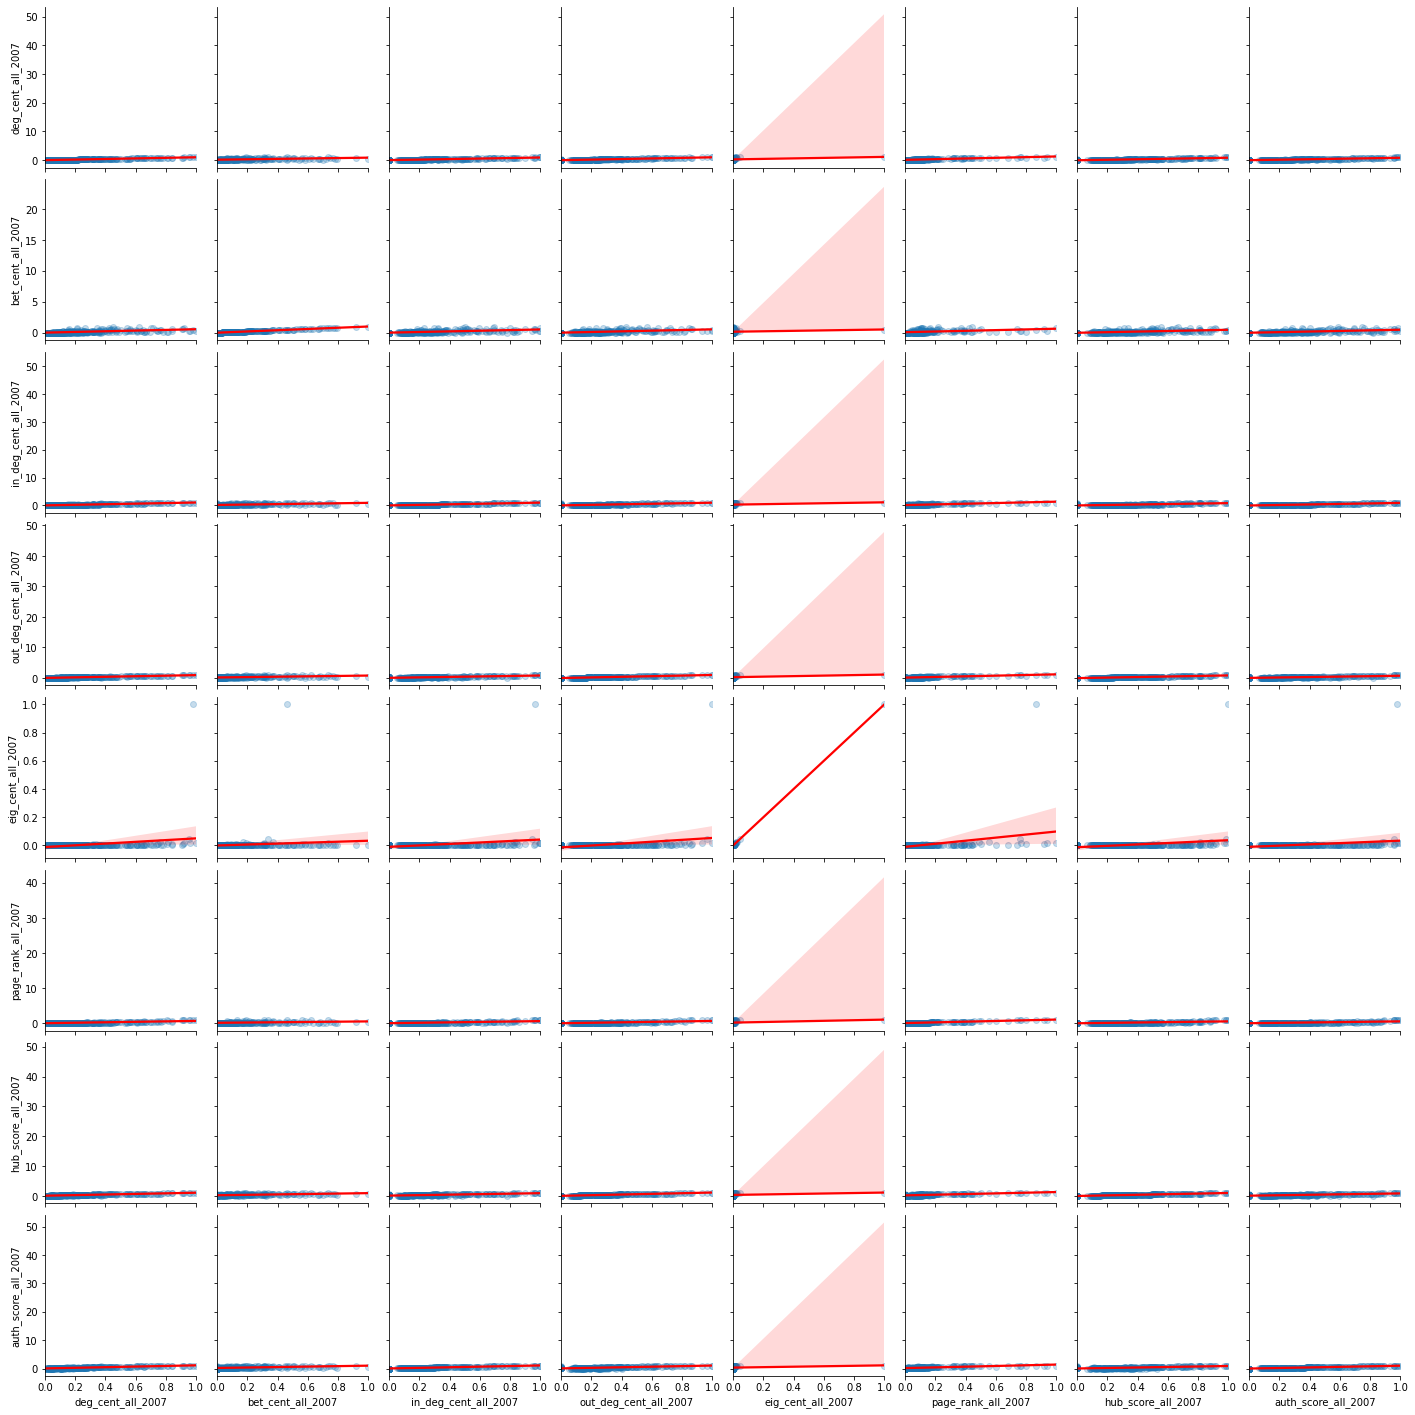

In [33]:
pair_plot_centrality(df, 2007)

In [82]:
test.head()

,deg_cent_all_2007,bet_cent_all_2007,in_deg_cent_all_2007,out_deg_cent_all_2007,eig_cent_all_2007,page_rank_all_2007,hub_score_all_2007,auth_score_all_2007,deg_cent_all_2011,bet_cent_all_2011,in_deg_cent_all_2011,out_deg_cent_all_2011,eig_cent_all_2011,page_rank_all_2011,hub_score_all_2011,auth_score_all_2011,deg_cent_Florida_cclass_2007,bet_cent_Florida_cclass_2007,in_deg_cent_Florida_cclass_2007,out_deg_cent_Florida_cclass_2007,eig_cent_Florida_cclass_2007,page_rank_Florida_cclass_2007,hub_score_Florida_cclass_2007,auth_score_Florida_cclass_2007,deg_cent_Florida_cclass_2011,bet_cent_Florida_cclass_2011,in_deg_cent_Florida_cclass_2011,out_deg_cent_Florida_cclass_2011,eig_cent_Florida_cclass_2011,page_rank_Florida_cclass_2011,hub_score_Florida_cclass_2011,auth_score_Florida_cclass_2011,deg_cent_Florida_ccore_2007,bet_cent_Florida_ccore_2007,in_deg_cent_Florida_ccore_2007,out_deg_cent_Florida_ccore_2007,eig_cent_Florida_ccore_2007,page_rank_Florida_ccore_2007,hub_score_Florida_ccore_2007,auth_score_Florida_ccore_2007,...,deg_cent_cy_math_2011,bet_cent_cy_math_2011,in_deg_cent_cy_math_2011,out_deg_cent_cy_math_2011,eig_cent_cy_math_2011,page_rank_cy_math_2011,hub_score_cy_math_2011,auth_score_cy_math_2011,deg_cent_cy_comm_2007,bet_cent_cy_comm_2007,in_deg_cent_cy_comm_2007,out_deg_cent_cy_comm_2007,eig_cent_cy_comm_2007,page_rank_cy_comm_2007,hub_score_cy_comm_2007,auth_score_cy_comm_2007,deg_cent_cy_comm_2011,bet_cent_cy_comm_2011,in_deg_cent_cy_comm_2011,out_deg_cent_cy_comm_2011,eig_cent_cy_comm_2011,page_rank_cy_comm_2011,hub_score_cy_comm_2011,auth_score_cy_comm_2011,deg_cent_cy_dynd_2007,bet_cent_cy_dynd_2007,in_deg_cent_cy_dynd_2007,out_deg_cent_cy_dynd_2007,eig_cent_cy_dynd_2007,page_rank_cy_dynd_2007,hub_score_cy_dynd_2007,auth_score_cy_dynd_2007,deg_cent_cy_dynd_2011,bet_cent_cy_dynd_2011,in_deg_cent_cy_dynd_2011,out_deg_cent_cy_dynd_2011,eig_cent_cy_dynd_2011,page_rank_cy_dynd_2011,hub_score_cy_dynd_2011,auth_score_cy_dynd_2011
10180,0.130435,0.000000,0.000000,0.130435,7.632138e-198,0.000628,0.002626,0.000000,0.097826,0.000000,0.000000,0.097826,0.000000,0.000628,0.002081,0.000000,0.065217,0.000000,0.000000,0.065217,1.887470e-134,0.000628,0.001838,0.000000,0.047101,0.000000,0.000000,0.047101,2.123411e-240,0.000629,0.001593,0.000000,0.036364,0.000000,0.000000,0.036364,1.348811e-123,0.000634,0.001561,0.000000,...,0.007299,0.000000,0.000000,0.007299,1.186535e-174,0.000626,0.000541,0.000000,0.039855,0.000000,0.000000,0.039855,8.847462e-113,0.000628,0.002011,0.000000,0.010870,0.000000,0.000000,0.010870,3.469016e-138,0.000629,0.001039,0.000000,0.029197,0.000000,0.000000,0.029197,2.224000e-110,0.000633,0.002311,0.000000,0.021739,0.000000,0.000000,0.021739,3.101593e-268,0.000627,0.002088,0.000000
10420,0.384058,0.009989,0.148551,0.235507,1.679679e-04,0.003233,0.004896,0.003316,0.427536,0.023341,0.188406,0.239130,0.000215,0.003317,0.004845,0.004056,0.275362,0.003376,0.101449,0.173913,2.344193e-04,0.002661,0.005398,0.003348,0.315217,0.004347,0.126812,0.188406,3.345574e-04,0.002532,0.005950,0.004138,0.152727,0.008299,0.069091,0.083636,3.745247e-04,0.002909,0.004502,0.003338,...,0.135036,0.011617,0.054745,0.080292,8.045327e-05,0.002586,0.005287,0.003348,0.141304,0.001278,0.050725,0.090580,2.832749e-05,0.002334,0.004712,0.003037,0.163043,0.024416,0.072464,0.090580,9.822386e-04,0.003388,0.004755,0.004492,0.091241,0.003623,0.029197,0.062044,1.820500e-05,0.002735,0.005622,0.001992,0.097826,0.003810,0.047101,0.050725,1.319919e-03,0.003945,0.003590,0.003392
10500,0.079710,0.000000,0.000000,0.079710,7.632138e-198,0.000628,0.001765,0.000000,0.065217,0.000000,0.000000,0.065217,0.000000,0.000628,0.001303,0.000000,0.032609,0.000000,0.000000,0.032609,1.887470e-134,0.000628,0.001161,0.000000,0.039855,0.000000,0.000000,0.039855,2.123411e-240,0.000629,0.001054,0.000000,0.003636,0.000000,0.000000,0.003636,1.348811e-123,0.000634,0.000338,0.000000,...,0.010949,0.000000,0.000000,0.010949,1.186535e-174,0.000626,0.001280,0.000000,0.018116,0.000000,0.0

In [73]:
df.columns

Index(['year', 'datanum', 'serial', 'hhwt', 'region', 'statefip', 'countyfips',
       'metarea', 'metaread', 'met2013', 'citypop', 'gq', 'pernum', 'perwt',
       'nchild', 'sex', 'age', 'marst', 'race', 'raced', 'hispan', 'hispand',
       'bpl', 'bpld', 'citizen', 'speakeng', 'racblk', 'racwht', 'educ',
       'educd', 'empstat', 'empstatd', 'labforce', 'ind', 'classwkr',
       'classwkrd', 'occsoc', 'indnaics', 'wkswork2', 'uhrswork', 'inctot',
       'incwage', 'migrate1', 'migrate1d', 'migplac1', 'migmet1', 'disabwrk',
       'diffrem', 'diffsens', 'pwmetro', 'Florida_cclass', 'Florida_ccore',
       'Florida_cprof', 'McGran_cclass', 'Wolff_know', 'Markusen_cclass',
       'Gabe_cclass', 'cy_high', 'cy_cclass', 'cy_math', 'cy_comm', 'cy_dynd',
       'migmet2013'],
      dtype='object')

In [4]:
from matplotlib.pyplot import figure
import networkx as nx

df = get_migmet_crosswalk()

In [20]:
df = get_migmet_crosswalk()

In [69]:
test = get_centrality_measures(df, 2011, 'all')

In [53]:
dict(network.nodes(data = True))[37980]

{'auth_score_all_2011': 0.009121915124045792,
 'bet_cent_all_2011': 0.004120333772507685,
 'deg_cent_all_2011': 1.0471014492753623,
 'eig_cent_all_2011': 0.02028587524991182,
 'hub_score_all_2011': 0.008988898000720847,
 'in_deg_cent_all_2011': 0.5144927536231884,
 'out_deg_cent_all_2011': 0.532608695652174,
 'page_rank_all_2011': 0.012572930180145322}

In [72]:
test.reset_index().query('index.isin([37980, 12420, 35620, 41860])', engine = 'python')

,index,deg_cent_all_2011,bet_cent_all_2011,in_deg_cent_all_2011,out_deg_cent_all_2011,eig_cent_all_2011,page_rank_all_2011,hub_score_all_2011,auth_score_all_2011
2,12420,0.869565,0.011998,0.503623,0.365942,0.002968,0.009929,0.006708,0.008712
60,35620,1.347826,0.012293,0.688406,0.659420,0.989798,0.023355,0.010055,0.010961
64,37980,1.047101,0.004120,0.514493,0.532609,0.020286,0.012573,0.008989,0.009122
75,41860,1.021739,0.013901,0.496377,0.525362,0.007623,0.011249,0.008674,0.008750


In [34]:
test = get_centrality_measures(df, 2011, 'all')
test.head()

,deg_cent_all_2011,bet_cent_all_2011,in_deg_cent_all_2011,out_deg_cent_all_2011,eig_cent_all_2011,page_rank_all_2011,hub_score_all_2011,auth_score_all_2011
10180,0.097826,0.000000,0.000000,0.097826,0.000000,0.000628,0.002081,0.000000
12260,0.623188,0.045495,0.355072,0.268116,0.000446,0.003545,0.005110,0.006684
12420,0.869565,0.011998,0.503623,0.365942,0.002968,0.009929,0.006708,0.008712
12540,0.431159,0.002512,0.228261,0.202899,0.000636,0.003978,0.003830,0.004570
17780,0.278986,0.000452,0.123188,0.155797,0.000149,0.002441,0.002977,0.002305


In [40]:
test = get_centrality_measures(df, 2011, 'all')
test.reset_index().head().rename(columns = {'index': 'cbsa_code'}).query('cbsa_code.isin([12420, 37980, 35620, 41860])', engine = 'python')

,cbsa_code,deg_cent_all_2011,bet_cent_all_2011,in_deg_cent_all_2011,out_deg_cent_all_2011,eig_cent_all_2011,page_rank_all_2011,hub_score_all_2011,auth_score_all_2011
2,12420,0.869565,0.011998,0.503623,0.365942,0.002968,0.009929,0.006708,0.008712


In [48]:
df.query('met2013 == 37980 & metaread != 0 & migmet2013 != 0 & migmet1 != 0 & year == 2011 & migmet2013 != met2013')[['met2013', 'migmet2013']].shape

(1433, 2)

In [6]:
?migMet2011 = df\
    .query('migmet1 != 0 & metaread != 0 & met2013 != 0 & migmet2013 != 0 & year == 2011')\
    .groupby(['migmet2013', 'met2013'])['perwt']\
    .sum()\
    .to_frame()\
    .reset_index()\
    .assign(migmet2013 = lambda x: x['migmet2013'].astype('int64'))

G = nx.from_pandas_edgelist(migMet2011, source = 'migmet2013', target = 'met2013', edge_attr = 'perwt', create_using = nx.DiGraph())
nx.set_node_attributes(G, nx.degree_centrality(G), 'deg_cent')
nx.set_node_attributes(G, nx.betweenness_centrality(G, normalized = True, weight = 'perwt'), 'bet_cent')
nx.set_node_attributes(G, nx.in_degree_centrality(G), 'in_deg_cent')
nx.set_node_attributes(G, nx.out_degree_centrality(G), 'out_deg_cent')
nx.set_node_attributes(G, nx.eigenvector_centrality(G, weight = 'perwt'), 'eig_cent')
nx.set_node_attributes(G, nx.pagerank(G, weight = 'perwt'), 'page_rank')
nx.set_node_attributes(G, nx.hits(G)[0], 'hub_score')
nx.set_node_attributes(G, nx.hits(G)[1], 'auth_score')

deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G, normalized = True, weight = 'perwt')
in_deg_cent = nx.in_degree_centrality(G)
out_deg_cent = nx.out_degree_centrality(G)
eig_cent = nx.eigenvector_centrality(G, weight = 'perwt')
pr = nx.pagerank(G, weight = 'perwt')
hubs, auth = nx.hits(G)

print('Deg Cent - Austin: {}'.format(deg_cent[12420]) + ' Philadephia: {}'.format(deg_cent[37980]) + ' New York: {}'.format(deg_cent[35620]) + ' SF: {}'.format(deg_cent[41860]))
print('In Deg Cent - Austin: {}'.format(in_deg_cent[12420]) + ' Philadephia: {}'.format(in_deg_cent[37980]) + ' New York: {}'.format(in_deg_cent[35620]) + ' SF: {}'.format(in_deg_cent[41860]))
print('Out Deg Cent - Austin: {}'.format(out_deg_cent[12420]) + ' Philadephia: {}'.format(out_deg_cent[37980]) + ' New York: {}'.format(out_deg_cent[35620]) + ' SF: {}'.format(out_deg_cent[41860]))
print('Between Cent - Austin: {}'.format(bet_cent[12420]) + ' Philadephia: {}'.format(bet_cent[37980]) + ' New York: {}'.format(bet_cent[35620]) + ' SF: {}'.format(bet_cent[41860]))
print('Eig Cent - Austin: {}'.format(eig_cent[12420]) + ' Philadephia: {}'.format(eig_cent[37980]) + ' New York: {}'.format(eig_cent[35620]) + ' SF: {}'.format(eig_cent[41860]))
print('Page Rank - Austin: {}'.format(pr[12420]) + ' Philadephia: {}'.format(pr[37980]) + ' New York: {}'.format(pr[35620]) + ' SF: {}'.format(pr[41860]))
print('Hub Rank - Austin: {}'.format(hubs[12420]) + ' Philadephia: {}'.format(hubs[37980]) + ' New York: {}'.format(hubs[35620]) + ' SF: {}'.format(hubs[41860]))
print('Auth Rank - Austin: {}'.format(auth[12420]) + ' Philadephia: {}'.format(auth[37980]) + ' New York: {}'.format(auth[35620]) + ' SF: {}'.format(auth[41860]))

Deg Cent - Austin: 0.8695652173913043 Philadephia: 1.0471014492753623 New York: 1.3478260869565217 SF: 1.0217391304347827
In Deg Cent - Austin: 0.5036231884057971 Philadephia: 0.5144927536231884 New York: 0.6884057971014493 SF: 0.4963768115942029
Out Deg Cent - Austin: 0.36594202898550726 Philadephia: 0.532608695652174 New York: 0.6594202898550725 SF: 0.5253623188405797
Between Cent - Austin: 0.011998243302591133 Philadephia: 0.004120333772507685 New York: 0.012292929292929291 SF: 0.013900966183574882
Eig Cent - Austin: 0.002967899611026702 Philadephia: 0.02028587524991182 New York: 0.9897984433059109 SF: 0.007623394118252111
Page Rank - Austin: 0.009928533070804433 Philadephia: 0.012572930180145322 New York: 0.0233548161704158 SF: 0.01124943307570195
Hub Rank - Austin: 0.006707915603132601 Philadephia: 0.008988898000720847 New York: 0.010055210607869508 SF: 0.008673969799957822
Auth Rank - Austin: 0.008712037722510236 Philadephia: 0.009121915124045792 New York: 0.010961164357506405 SF

In [13]:
test = pd.DataFrame.from_dict(dict(G.nodes(data = True)), orient = 'index')
test.head()

,deg_cent,bet_cent,in_deg_cent,out_deg_cent,eig_cent,page_rank,hub_score,auth_score
10180,0.097826,0.000000,0.000000,0.097826,0.000000,0.000628,0.002081,0.000000
12260,0.623188,0.045495,0.355072,0.268116,0.000446,0.003545,0.005110,0.006684
12420,0.869565,0.011998,0.503623,0.365942,0.002968,0.009929,0.006708,0.008712
12540,0.431159,0.002512,0.228261,0.202899,0.000636,0.003978,0.003830,0.004570
17780,0.278986,0.000452,0.123188,0.155797,0.000149,0.002441,0.002977,0.002305


In [24]:
df[['metaread', 'migmet1', 'met2013', 'migmet2013', 'year', 'perwt', 'pernum']].query('migmet1 != 0 & metaread != 0 & met2013 != 0').head()

,metaread,migmet1,met2013,migmet2013,year,perwt,pernum
24,5160,5160,33660,33660.0,2007,33.0,1
62,3440,3440,26620,26620.0,2007,52.0,1
71,3440,2720,26620,22900.0,2007,53.0,6
74,1000,1000,13820,13820.0,2007,59.0,2
77,450,450,11500,11500.0,2007,41.0,1


In [29]:
df.groupby(['pernum', 'serial', 'year']).size().to_frame().head().rename(columns = {0: 'v_count'}).query('v_count > 1')

,,,v_count
pernum,serial,year,


In [16]:
df_2007 = df\
    .copy()\
    .query('year == 2007 & migmet1 != 0 & metaread != 0 & migmet1 != metaread')

df_2007.head()

,year,datanum,serial,hhwt,region,statefip,countyfips,metarea,metaread,met2013,citypop,gq,pernum,perwt,nchild,sex,age,marst,race,raced,hispan,hispand,bpl,bpld,citizen,speakeng,racblk,racwht,educ,educd,empstat,empstatd,labforce,ind,classwkr,classwkrd,occsoc,indnaics,wkswork2,uhrswork,inctot,incwage,migrate1,migrate1d,migplac1,migmet1,disabwrk,diffrem,diffsens,pwmetro,Florida_cclass,Florida_ccore,Florida_cprof,McGran_cclass,Wolff_know,Markusen_cclass,Gabe_cclass,cy_high,cy_cclass,cy_math,cy_comm,cy_dynd
71,2007,3,82.0,38.0,32,1,0,344,3440,26620,0,1,6,53.0,1,1,33,3,1,100,0,0,1,100,0,3,1,2,6,62,1,10,2,3370,2,22,434051,334M1,6,40,27603,27603,3,32,5,2720,1.0,1,1,3440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
109,2007,3,130.0,8.0,32,1,0,524,5240,33860,0,1,1,8.0,0,2,63,1,1,100,0,0,1,100,0,3,1,2,6,62,1,10,2,7070,2,22,119141,531,2,40,71609,63700,3,32,48,1921,1.0,1,1,5240,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
135,2007,3,165.0,24.0,32,1,73,100,1000,13820,0,1,1,23.0,0,1,46,1,1,100,0,0,453,45300,2,4,1,2,11,116,1,10,2,8190,2,27,113021,622,6,40,212332,180482,3,32,51,8840,1.0,1,1,1840,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
302,2007,3,325.0,103.0,32,1,0,524,5240,33860,2008,1,1,101.0,0,1,25,6,2,200,0,0,28,2800,0,3,2,1,10,101,1,10,2,9470,2,25,332011,92MP,6,72,40343,37158,2,24,1,2030,1.0,1,1,5240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
317,2007,3,344.0,6.0,32,1,0,218,2180,0,0,1,1,6.0,0,1,63,1,1,100,0,0,1,100,0,3,1,2,7,71,1,10,2,6670,2,22,112020,51M,6,45,91303,91303,2,24,1,5240,1.0,1,1,2180,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
df.query('migmet1 != 0 & metaread != 0 & migmet1 != metaread').groupby(['migmet1', 'metaread']).size()

migmet1  metaread
40       320          2
         520          1
         600          1
         640         11
         680          3
                     ..
9360     7840         2
         8200         1
         8520        17
         8840         4
         8940         2
Length: 26515, dtype: int64

In [ ]:
G = nx.Graph()
G = nx.from_pandas_edgelist()

In [24]:
test = get_epop_detail_ratio(2011)
test.head()

,cbsa_s,cbsa_r,epop_s,epop_r,epop_ratio
0,21740,21740,0.72,0.720,1.000000
1,21740,21780,0.72,0.650,0.902778
2,21740,21820,0.72,0.733,1.018056
3,21740,21860,0.72,0.654,0.908333
4,21740,21900,0.72,0.581,0.806944


In [111]:
test = pd.read_parquet('/content/gdrive/My Drive/dissertation/ipums_mig.parquet')

In [153]:
locdf = pd.read_excel('/content/gdrive/My Drive/dissertation/metareaGeoCoded2.xlsx')\
    .set_index('MSA')
locdf.head()

loc2df = get_msa_by_county()

loc2df = loc2df[['cbsa_code', 'cbsa_name']].drop_duplicates().sort_values(['cbsa_code']).assign(cbsa_code = lambda x: x['cbsa_code'].astype(int)).set_index('cbsa_code')

loc2df.head()

,cbsa_name
cbsa_code,
10180,"Abilene, TX"
10380,"Aguadilla-Isabela, PR"
10420,"Akron, OH"
10500,"Albany, GA"
10540,"Albany, OR"


In [154]:
test2 = test.groupby(['metaread', 'met2013']).size().to_frame().rename(columns = {0: 'v_count'}).reset_index().sort_values(['metaread', 'v_count'], ascending = [True, False])

test2\
    .query('metaread != 0')\
    .groupby('metaread')\
    .head(1)\
    .assign(metname = lambda x: x['metaread'].map(locdf['MSANames']), 
            newName = lambda x: x['met2013'].map(loc2df['cbsa_name']))\
        [['metaread', 'metname', 'met2013', 'newName', 'v_count']].to_excel('/content/gdrive/My Drive/dissertation/metareas_crosswalk.xlsx')

#test2.query('metaread != 0').groupby('metaread').head(1).query('met2013 == 0')

In [109]:
get_rent_and_pop_acs_detail(2007).head()

,cbsa_code,cbsa_name,median_rent_2007,total_pop_2007,pctOver65_2007
1,35900,"North Wilkesboro, NC Micro Area",505,66675,0.153941
2,10020,"Abbeville, LA Micro Area",468,55351,0.135101
3,10100,"Aberdeen, SD Micro Area",458,39000,0.172179
4,10140,"Aberdeen, WA Micro Area",604,70793,0.150184
5,10180,"Abilene, TX Metro Area",662,159005,0.134820


In [107]:
get_distances().query('cbsa_s == "6160" & cbsa_r == "5600"').head()

,cbsa_s,cbsa_r,lat_s,lon_s,lat_r,lon_r,coordinates_s,coordinates_r,distance
56343,6160,5600,39.952584,-75.165222,40.712784,-74.005941,"(39.9525839, -75.1652215)","(40.7127837, -74.0059413)",80.610551


In [105]:
get_distances_2013().query('cbsa_s == "37980" & cbsa_r == "35620"').head()

,cbsa_s,cbsa_r,lat_s,lon_s,lat_r,lon_r,coordinates_s,coordinates_r,distance
59977,37980,35620,39.952584,-75.165222,40.712784,-74.005941,"(39.9525839, -75.1652215)","(40.7127837, -74.00594129999999)",80.610551


In [81]:
get_comp().query('cbsa_name.str.contains("Philadelphia|New York|Akron")', engine = 'python')

,cbsa_code,cbsa_name,comp_2007,comp_2011
2,10420,"Akron, OH (Metropolitan Statistical Area)",49657,53824
250,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",78104,82107
270,37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD (M...",62052,67213


In [82]:
test = pd.read_excel('/content/gdrive/My Drive/dissertation/metareaGeoCoded2.xlsx', dtype = {'MSA': np.str})
test.query('MSAGeoNames.str.contains("Akron|Philadelphia|New York|Los")', engine = 'python')

,MSA,MSANames,MSAGeoNames,lon,lat,address
1,0080,"Akron, OH","Akron, OH",-81.519005,41.081445,"akron, oh, usa"
154,4480,"Los Angeles-Anaheim-Riverside, CA CMSA","Los Angeles, CA",-118.243685,34.052234,"los angeles, ca, usa"
183,5600,"New York-Northern New Jersey-Long Island, NY-N...","New York, NY",-74.005941,40.712784,"new york, ny, usa"
195,6160,"Philadelphia-Wilmington-Trenton, PA-NJ-DE-MD CMSA","Philadelphia, PA",-75.165222,39.952584,"philadelphia, pa, usa"


In [77]:
test.head()

,MSA,MSANames,MSAGeoNames,lon,lat,address
0,0040,"Abilene, TX MSA","Abilene, TX",-99.733144,32.448736,"abilene, tx, usa"
1,0080,"Akron, OH","Akron, OH",-81.519005,41.081445,"akron, oh, usa"
2,0120,"Albany, GA MSA","Albany, GA",-84.155741,31.578507,"albany, ga, usa"
3,0160,"Albany-Schenectady-Troy, NY MSA","Albany, NY",-73.756232,42.652579,"albany, ny, usa"
4,0200,"Albuquerque, NM MSA","Albuquerque, NM",-106.605553,35.085334,"albuquerque, nm, usa"


In [74]:
get_density_ratio().query('cbsa_s == "37980"')

,cbsa_s,cbsa_r,density_2007_s,density_2007_r,density_2007_ratio,density_2007_ratio_n,density_2011_s,density_2011_r,density_2011_ratio,density_2011_ratio_n
94428,37980,10180,31000.323862,2888.035896,0.093161,-0.323440,31939.467884,2699.081739,0.084506,-0.237691
94429,37980,10420,31000.323862,5187.289467,0.167330,-0.310154,31939.467884,4414.436332,0.138213,-0.231122
94430,37980,10500,31000.323862,2316.488285,0.074725,-0.326743,31939.467884,1858.607823,0.058192,-0.240910
94431,37980,10580,31000.323862,11381.398808,0.367138,-0.274363,31939.467884,11790.836836,0.369162,-0.202874
94432,37980,10740,31000.323862,4261.185488,0.137456,-0.315506,31939.467884,4055.363616,0.126970,-0.232497
...,...,...,...,...,...,...,...,...,...,...
94789,37980,49420,31000.323862,6478.630551,0.208986,-0.302693,31939.467884,6855.420042,0.214638,-0.221774
94790,37980,49620,31000.323862,12421.129016,0.400677,-0.268355,31939.467884,13158.065068,0.411969,-0.197638
94791,37980,49660,31000.323862,2058.509400,0.066403,-0.328233,31939.467884,1614.517200,0.050549,-0.241844
94792,37980,49700,31000.323862,4274.821193,0.137896,-0.315427,31939.467884,4549.142564,0.142430,-0.230606


In [121]:
%%time
df = get_distances()

CPU times: user 23.2 s, sys: 47.6 ms, total: 23.3 s
Wall time: 23.3 s


In [118]:
df = get_distances()\
    .set_index('MSA')


pairs = pd.DataFrame(index = pd.MultiIndex.from_product([df.index.tolist(), df.index.to_list()]))\
    .reset_index()\
    .rename(columns = {'level_0': 'cbsa_s', 'level_1': 'cbsa_r'})\
    .assign(lat_s = lambda x: x['cbsa_s'].map(df['lat']), 
            lon_s = lambda x: x['cbsa_s'].map(df['lon']), 
            lat_r = lambda x: x['cbsa_r'].map(df['lat']), 
            lon_r = lambda x: x['cbsa_r'].map(df['lon']), 
            coordinates_s = lambda x: tuple(zip(x['lat_s'], x['lon_s'])), 
            coordinates_r = lambda x: tuple(zip(x['lat_r'], x['lon_r'])), 
            distance = lambda x: vectorized_distance_calc(x['coordinates_s'], x['coordinates_r']))


pairs.head()    

,cbsa_s,cbsa_r,lat_s,lon_s,lat_r,lon_r,coordinates_s,coordinates_r,distance
0,0040,0040,32.448736,-99.733144,32.448736,-99.733144,"(32.4487364, -99.73314390000002)","(32.4487364, -99.73314390000002)",0.000000
1,0040,0080,32.448736,-99.733144,41.081445,-81.519005,"(32.4487364, -99.73314390000002)","(41.0814447, -81.51900529999999)",1169.268095
2,0040,0120,32.448736,-99.733144,31.578507,-84.155741,"(32.4487364, -99.73314390000002)","(31.5785074, -84.15574099999999)",915.647527
3,0040,0160,32.448736,-99.733144,42.652579,-73.756232,"(32.4487364, -99.73314390000002)","(42.6525793, -73.7562317)",1581.642374
4,0040,0200,32.448736,-99.733144,35.085334,-106.605553,"(32.4487364, -99.73314390000002)","(35.0853336, -106.6055534)",435.186219


In [129]:
df.query('cbsa_s == "4480" & cbsa_r == "6160"')

,cbsa_s,cbsa_r,lat_s,lon_s,lat_r,lon_r,coordinates_s,coordinates_r,distance
44547,4480,6160,34.052234,-118.243685,39.952584,-75.165222,"(34.0522342, -118.2436849)","(39.9525839, -75.1652215)",2393.483616


In [ ]:
from sklearn.neighbors import DistanceMetric
df = get_distances()\
    .set_index('MSA')
dist = DistanceMetric.get_metric('haversine')
test = pd.DataFrame(dist.pairwise(df[['lat','lon']].to_numpy())*3958,  columns=df.index, index=df.index)
test.head()

MSA,0040,0080,0120,0160,0200,0220,0240,0280,0320,0380,0440,0450,0460,0480,0500,0520,0560,0580,0600,0640,0680,0720,0730,0740,0760,0840,0860,0870,0880,0920,0960,1000,1020,1040,1080,1120,1150,1160,1200,1240,...,8000,8040,8050,8120,8140,8160,8200,8240,8280,8320,8400,8440,8480,8520,8560,8600,8640,8680,8730,8760,8780,8800,8840,8880,8920,8940,8960,9000,9040,9080,9140,9160,9200,9240,9260,9270,9280,9320,9340,9360
MSA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0040,0.000000,8790.218281,7684.775363,9589.634536,9890.940811,5486.451846,6678.431566,3375.133988,7533.789654,10474.385103,9804.761389,3685.749797,4618.769748,9366.048265,2414.232752,1232.340282,2497.803999,2696.278374,3384.906879,10384.445445,11099.808675,2095.912806,1369.528980,8365.843652,10657.296921,9526.800179,10457.072721,10992.251889,1504.201523,9702.971751,10288.380908,4165.126274,1812.723241,4495.770488,9007.632083,10116.398745,6549.548501,7719.703649,9089.187590,4717.029942,...,9581.324254,7956.494204,3917.488633,7135.579508,5589.243652,9194.603538,5128.659074,11851.616905,5116.403559,2890.249209,7502.954513,2728.293772,5861.391294,3207.539168,10388.263618,2960.115055,3635.623512,7844.710106,6825.610510,2928.965955,9654.510768,7495.476411,3340.886752,8632.439302,10144.903155,4197.763910,2161.123726,5252.548216,7799.202379,4664.757073,6164.292624,3523.726356,2834.953608,9743.532184,3761.630236,4250.499124,2315.593610,9296.221560,2639.317602,3036.674882
0080,8790.218281,0.000000,2545.645896,5378.146345,1148.683859,5852.884502,2121.243366,12106.034827,5300.772016,5138.386663,5583.285917,7941.757603,10086.738379,4332.330799,7619.699784,10010.936749,6911.241452,6129.792233,5461.470621,3847.954090,2370.233083,7154.208188,10073.901832,4923.964742,2901.717286,6193.906526,5050.601281,5050.666221,7394.067964,6355.999852,4330.504717,5971.921523,7285.306810,5201.670485,712.866924,5369.110832,9528.672014,7560.200754,5911.856671,4114.135673,...,6350.135949,6491.435048,10271.539843,4628.556312,5591.935220,6860.805641,10933.785295,3137.985623,4287.187871,6447.166213,6699.165107,7120.339298,3887.189705,5768.829224,5231.098960,6309.952517,7812.815767,7993.002438,2072.901454,6331.395985,6061.425404,1514.105797,6790.218720,7276.953005,5212.480941,6452.328199,7165.090100,4943.063146,991.564980,7742.511349,6533.652044,5394.720273,10754.138725,5829.500904,5756.000414,5347.396453,6751.612345,3328.341827,6789.460220,6989.720654
0120,7684.775363,2545.645896,0.000000,7379.483410,3241.979595,7980.255981,2955.960791,9634.877945,7846.180065,6694.919995,7333.357956,5456.174020,7718.285659,6703.730144,8172.584442,8503.720862,5218.081687,5262.584060,4614.808660,5965.486413,4019.860971,5598.595629,8378.996591,7430.000942,5005.289234,7648.596741,6685.603441,6075.429329,6222.086622,6729.401166,6376.773685,3761.930161,5872.060853,6452.120294,3254.389876,7036.008136,9310.344582,6305.778635,7936.092649,3575.397765,...,7492.657696,4918.274413,11602.202903,2213.873009,3054.434394,7096.524954,10123.195112,4531.837225,5538.250381,4800.336916,9135.014617,5153.417568,1825.426897,5936.434765,6784.871456,4724.809455,5348.795222,9151.211436,2044.703759,4755.864028,7524.187091,1665.699446,4648.005501,6961.996870,6963.801255,4074.021819,5546.980363,2630.159098,2493.647009,5199.379258,9007.692460,4359.135948,10457.533523,7436.343764,6643.703863,3451.460422,6756.553624,2198.192014,5076.138889,4916.715265
0160,9589.634536,5378.146345,7379.483410,0.000000,4321.604382,4861.741063,6956.885865,7384.310763,2656.778290,1085.246996,584.216839,10565.182405,7770.469227,1442.119135,7672.862036,8985.042297,11735.306138,10196.815095,9986.503464,1530.202074,3362.564606,11402.224656,9104.004862,1926.354236,2489.482695,1292.409092,971.976962,2116.331296,10577.425456,3019.763052,1051.916257,11099.941914,11072.332271,6771.075558,4777.408884,775.281757,4684.680357,5665.231277,559.267988,8990.370180,...,1819.983774,6307.663714,5858.820948,8108.868389,9639.558010,3273.499241,5715.264057,2892.436424,6770.

In [ ]:
get_comp().tail()

,cbsa_code,cbsa_name,epop_2007,epop_2011
380,49420,"Yakima, WA (Metropolitan Statistical Area)",40911,43955
381,49620,"York-Hanover, PA (Metropolitan Statistical Area)",49032,53887
382,49660,"Youngstown-Warren-Boardman, OH-PA (Metropolita...",44444,46939
383,49700,"Yuba City, CA (Metropolitan Statistical Area)",48896,54926
384,49740,"Yuma, AZ (Metropolitan Statistical Area)",40799,46374


In [ ]:
get_epop_detail(2007).query('cbsa_name.str.contains("Yuma") == True', engine = 'python')

,cbsa_code,cbsa_name,epop
180,49740,"Yuma, AZ Metro Area",0.548


In [ ]:
get_rent_and_pop_acs_detail(2011).head()


,cbsa_code,cbsa_name,median_rent,total_pop,over65,pctOver65
1,10020,"Abbeville, LA Micro Area",595,58015,7522,0.129656
2,10100,"Aberdeen, SD Micro Area",526,40604,6763,0.166560
3,10140,"Aberdeen, WA Micro Area",689,72628,11751,0.161797
4,10180,"Abilene, TX Metro Area",734,165325,22374,0.135333
5,10220,"Ada, OK Micro Area",599,37556,5629,0.149883


In [ ]:
get_amenity_by_metro().head()

amenity_scale             
                                               mean median  amax
cbsa_code cbsa_name                                             
10180     Abilene, TX                         2.040  2.040  2.04
10420     Akron, OH                          -2.285 -2.285 -2.17
10500     Albany, GA                         -0.045 -0.045  0.22
10540     Albany, OR                          3.650  3.650  3.65
10580     Albany-Schenectady-Troy, NY        -0.535 -0.190  0.30